In [1]:
# import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

e:\python3.9\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df_movies = pd.read_csv(
    'movies.csv',
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    'ratings.csv',
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int32 
 1   title    58098 non-null  object
dtypes: int32(1), object(1)
memory usage: 681.0+ KB


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 317.6 MB


In [5]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [7]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 283228 unique users and 53889 unique movies in this data set


Exploratory data analysis

Plot the counts of each rating

In [8]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


Including zero rating score in the dataframe

In [9]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,15235120248
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


In [10]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,15235120248,23.446869
0.5,442388,12.999943
1.0,886233,13.694735
1.5,441354,12.997603
2.0,1850627,14.431035
2.5,1373419,14.132814
3.0,5515668,15.523103
3.5,3404360,15.040568
4.0,7394710,15.816275
4.5,2373550,14.679897


Text(0, 0.5, 'number of ratings')

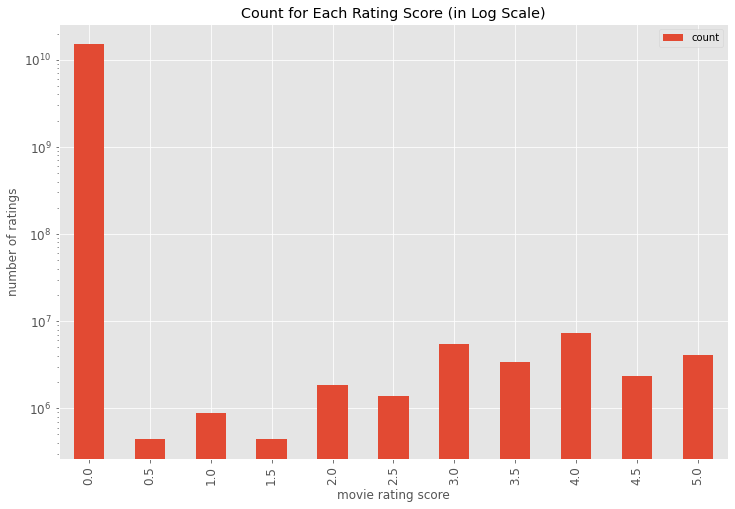

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Plot rating frequency of all movies

In [12]:
df_ratings.head()


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [13]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(0, 0.5, 'number of ratings')

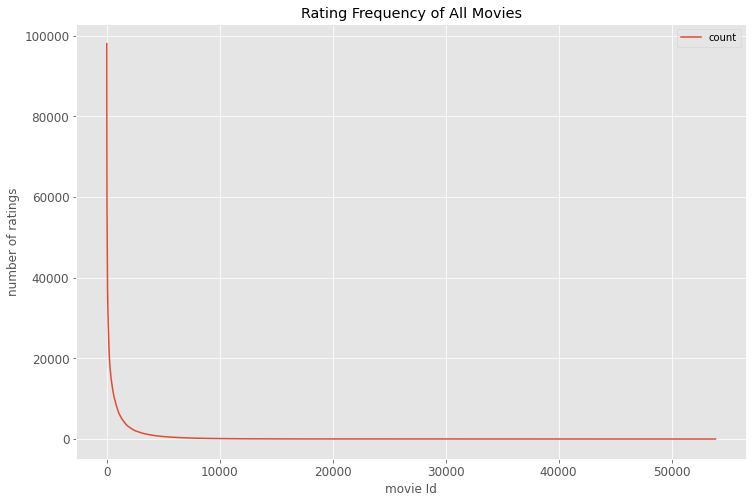

In [14]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

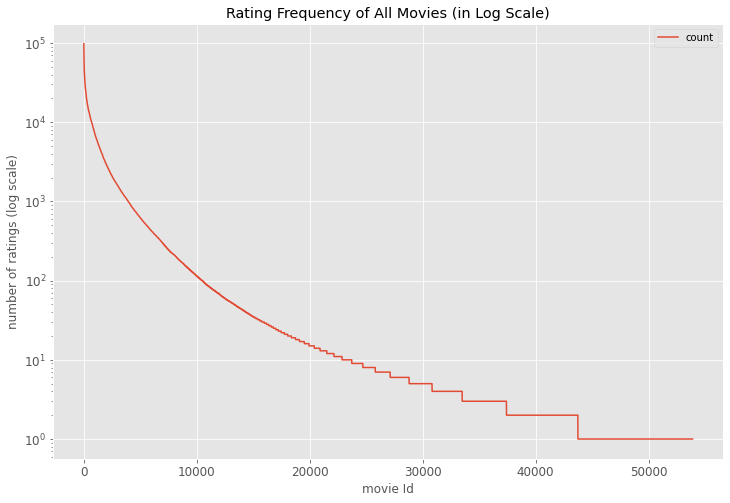

In [15]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [16]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
Name: count, dtype: float64

In [17]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies:  (27430748, 3)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(0, 0.5, 'number of ratings')

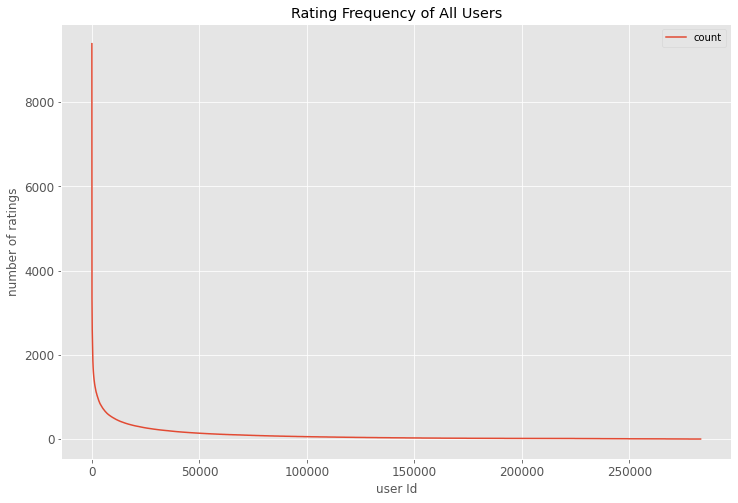

In [19]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
0.55      37.0
Name: count, dtype: float64

In [21]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (24178982, 3)


Training the KNN Model for item-based collaborative filtering

Reshaping the data

In [22]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))}
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

Fitting the data

In [23]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

Use this trained model to make movie recommendations

In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [25]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Bourne Ultimatum, The (2007), with distance of 0.4217848777770996
2: Sherlock Holmes (2009), with distance of 0.4190899133682251
3: Inception (2010), with distance of 0.39293038845062256
4: Avatar (2009), with distance of 0.38322633504867554
5: WALL·E (2008), with distance of 0.38314002752304077
6: Star Trek (2009), with distance of 0.37503182888031006
7: Batman Begins (2005), with distance of 0.3701704144477844
8: Iron Man 2 (2010), with distance of 0.37011009454727173
9: Avengers, The (2012), with distance of 0.3579972982406616
10: Dark Knight, The (2008), with distance of 0.3010351061820984
